# **EDA — Dermatoscopia (Melanoma CNN)**
**Propósito.** Entender el conjunto de imágenes dermatoscópicas para **detectar riesgos** (bordes negros/viñeteado, pelo, desenfoque, duplicados, desbalanceo) y **medir señales de color** que justifiquen el preprocesado y los perfiles de entrada (`RGB`, `RGB + H`, `RGB + S`, etc.).

**Contexto del caso.** Clasificación binaria (Benign / Malignant) para apoyar la decisión clínica con métricas relevantes (sensibilidad, especificidad, ROC-AUC) y explicabilidad (p. ej. Grad-CAM). Este cuaderno no entrena modelos; **prepara decisiones** para las fases de preprocesado y entrenamiento posteriores.


In [3]:
import os, io, json, pathlib, random, re, warnings, math
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import requests
from dotenv import load_dotenv
import cv2
import seaborn as sns


from src.utils.config import load_config
from src.utils.reproducibility import set_global_determinism

## **Configuración de entorno y utilidades de acceso**
Este módulo se encarga de cargar la configuración, las rutas y la semilla del proyecto. Además, define utilidades para reconstruir URLs firmadas y descargar imágenes desde Azure sin exponer el token SAS en los archivos CSV.

Su propósito principal es **garantizar la reproducibilidad de los experimentos** mediante una semilla fija y asegurar un acceso confiable a los datos.

Asimismo, centraliza la lectura de variables en los archivos `config/base.yaml` y `.env`, lo que permite mantener el código más limpio, ordenado y fácilmente portable entre distintos entornos.

In [4]:
# Set working directory to project root
os.chdir(Path.cwd().parent)

In [5]:
plt.rcParams["figure.dpi"] = 110 # MatPlotLib resolution

# Settings config and paths
load_dotenv()
CFG = load_config("config/base.yaml")
set_global_determinism(CFG["seed"])

[OK] Determinism configured with seed=1337


In [6]:
# Azure access variables: Also available in base.yaml
ACC_URL   = os.getenv("AZURE_ACCOUNT_URL")
CONTAINER = os.getenv("AZURE_CONTAINER_RAW")
SAS       = os.getenv("AZURE_SAS_TOKEN")

In [7]:
# Paths setup
MANIFESTS_DIR = pathlib.Path(CFG["paths"]["manifests_dir"])
RESULTS_ROOT  = pathlib.Path(CFG["paths"]["results_dir"])
print(f"[INFO] Manifests directory: {MANIFESTS_DIR}")
print(f"[INFO] Results directory: {RESULTS_ROOT}")

[INFO] Manifests directory: data\manifests
[INFO] Results directory: results


In [8]:
# Basic constants
IMG_SIZE = int(CFG["img_size"])
SEED = CFG["seed"]
print(f"[INFO] Image size: {IMG_SIZE}, Seed: {SEED}")

[INFO] Image size: 224, Seed: 1337


In [9]:
def to_signed_url(path_internal: str) -> str:
    """
    Reconstruct signed URL locally (without exposing SAS in CSV).
    Args:
        - path_internal (str): Internal path within the container.
    """
    return f"{ACC_URL}/{CONTAINER}/{path_internal}{SAS}"

def fetch_image_signed(path_internal: str, mode="RGB") -> Image.Image:
    """
    Fetch image from Azure Blob Storage using signed URL.
    Args:
        - path_internal (str): Internal path within the container.
        - mode (str): Image mode to convert to (default: "RGB").
    """
    url = to_signed_url(path_internal)
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    return Image.open(io.BytesIO(r.content)).convert(mode)

print("[OK] Config:", {"img_size": IMG_SIZE, "batch": CFG["batch_size"]})
print("[OK] Paths:", {"manifests": str(MANIFESTS_DIR), "results": str(RESULTS_ROOT)})

[OK] Config: {'img_size': 224, 'batch': 32}
[OK] Paths: {'manifests': 'data\\manifests', 'results': 'results'}


## **Carga de manifests**
Este bloque **abre los archivos CSV** generados durante la **Fase 1** del proyecto, los cuales contienen las **rutas internas** de las imágenes tanto de entrenamiento como de prueba. Estos ficheros son fundamentales para iniciar el **análisis exploratorio de datos (EDA)**, ya que permiten acceder a los conjuntos correctamente estructurados y clasificados.

A continuación, el código **muestra las primeras filas** de cada CSV y realiza **conteos por clase**. Este paso actúa como una **verificación básica o sanity check**, asegurando que los datos se han importado correctamente y que la distribución de clases es coherente antes de continuar con el análisis.

Además, el notebook **guarda instantáneas (snapshots)** de los datos utilizados en este EDA. Esto garantiza la **trazabilidad** del proceso, es decir, la posibilidad de saber exactamente qué versión de los datos se utilizó para cada experimento, manteniendo así la **reproducibilidad** del proyecto.

Por último, se incluye una **comprobación manual**: el número de filas debe ser **razonable** (coherente con el tamaño del dataset) y las clases deben aparecer con un conteo similar a `{ 'Benign': X, 'Malignant': Y }` en los conjuntos de **train** y **test**.

In [10]:
train_df = pd.read_csv(MANIFESTS_DIR / "train_manifest.csv")
test_df  = pd.read_csv(MANIFESTS_DIR / "test_manifest.csv")

display(train_df.head(3), test_df.head(3))

path   label  \
0    automatic-learning/melanoma/train/Benign/1.jpg  Benign   
1   automatic-learning/melanoma/train/Benign/10.jpg  Benign   
2  automatic-learning/melanoma/train/Benign/100.jpg  Benign   

                               hash  width  height  split  
0  11958b640adfaa3c7d26287cbc04705d    224     224  train  
1  7a560781b891e755e3dd8259798f76dd    224     224  train  
2  4a8a2aa26620d5bd7bac36d6df79dd5f    224     224  train

path   label  \
0  automatic-learning/melanoma/test/Benign/6299.jpg  Benign   
1  automatic-learning/melanoma/test/Benign/6300.jpg  Benign   
2  automatic-learning/melanoma/test/Benign/6301.jpg  Benign   

                               hash  width  height split  
0  7bcc932f1c806db9d15c468990a6366a    224     224  test  
1  d0d0c8f0b6eb4f0a3d4eaa7602515dc5    224     224  test  
2  0f1e4ee9652b2d668b2dbcc015ceb4ee    224     224  test

In [11]:
print("Train rows:", len(train_df), "| Test rows:", len(test_df))
print("Train classes:", train_df["label"].value_counts().to_dict())
print("Test  classes:", test_df["label"].value_counts().to_dict())

Train rows: 11879 | Test rows: 2000
Train classes: {'Benign': 6289, 'Malignant': 5590}
Test  classes: {'Benign': 1000, 'Malignant': 1000}


## **Reporte de clases y tamaños por clase**
Este bloque **calcula el ratio de desbalance de clases**, es decir, la proporción entre la **clase mayoritaria y la minoritaria** dentro del conjunto de datos. Este indicador permite evaluar si existe un **desequilibrio significativo** entre las categorías *Benign* y *Malignant*, lo cual podría afectar al rendimiento del modelo durante el entrenamiento.

Además, el script **mide el tamaño medio de las imágenes por clase**, obteniendo el **ancho (width)** y **alto (height)** promedio de las muestras pertenecientes a cada categoría. Este análisis ayuda a identificar posibles **diferencias de resolución o encuadre** que podrían introducir **sesgos** antes de aplicar el redimensionamiento estándar.

Este paso es importante porque un **ratio superior a 1.5–2** indica un **desbalance considerable**, lo que sugiere la necesidad de aplicar **class weights** (pesos por clase) o un **muestreo estratificado** para compensar la diferencia durante el entrenamiento.
Asimismo, las **disparidades en el tamaño medio de las imágenes** podrían reflejar diferencias en la procedencia o formato de captura, factores que conviene conocer aunque posteriormente todas las imágenes se **redimensionen a 224×224 píxeles**.

Finalmente, la **comprobación visual** debe mostrar un valor de **“Ratio max/min”** junto con una **tabla de medidas promedio (width/height) por clase**. Si los valores son coherentes y el ratio está dentro de límites razonables, se puede continuar con el EDA sin aplicar correcciones adicionales.

In [12]:
def class_report(df, name):
    """
    Print class distribution and size statistics.
    Args:
        - df (pd.DataFrame): DataFrame with 'label', 'width', 'height'
        - name (str): Name of the dataset (e.g., 'train', 'test')
    """
    vc = df['label'].value_counts()
    ratio = (vc.max() / vc.min()) if len(vc)>1 and vc.min()>0 else np.nan
    size_tbl = df.groupby('label')[['width','height']].mean().round(1)
    print(f"== {name.upper()} ==")
    print(vc.to_string())
    print("Ratio max/min:", round(ratio, 2))
    display(size_tbl)

In [13]:
class_report(train_df, "train")

== TRAIN ==
label
Benign       6289
Malignant    5590
Ratio max/min: 1.13


width  height
label                   
Benign     224.0   224.0
Malignant  224.0   224.0

In [14]:
class_report(test_df, "test")

== TEST ==
label
Benign       1000
Malignant    1000
Ratio max/min: 1.0


width  height
label                   
Benign     224.0   224.0
Malignant  224.0   224.0

El análisis muestra que el **balance de clases** en el conjunto de entrenamiento es **muy leve**, lo que representa un **ratio de 1.13**. Este nivel de desbalance se considera **aceptable** y **no requiere corrección obligatoria**.

En el conjunto de prueba, la distribución es **perfectamente equilibrada**, lo cual garantiza **métricas comparables y justas** durante la evaluación.

En cuanto a los **tamaños medios de las imágenes**, se confirma que todas están **uniformemente normalizadas a 224×224 píxeles**. No existen diferencias entre clases, lo que elimina la posibilidad de **sesgos geométricos**. Esto también implica que **no es necesario aplicar recortes ni padding adicional**, ya que el dataset está listo para ser usado directamente en el modelo.

<u>**Decisiones Técnicas**</u>

1. **Uso de class weights:** Dado el desbalanceo mínimo, se recomienda **entrenar sin pesos de clase**. La activación de estos pesos debe evaluarse solo si la **sensibilidad (recall)** de la clase positiva resulta baja.

2. **Métricas de evaluación:** Al existir un leve desbalanceo, las métricas más informativas serán la **sensibilidad (Recall)**, la **especificidad**, y el **ROC-AUC**. También puede considerarse la **PR-AUC** para la clase Malignant si se priorizan los verdaderos positivos. El **baseline de precisión (accuracy)** del modelo trivial que siempre predice la clase mayoritaria es de aproximadamente **52.94 %**, por lo que los resultados deben mejorar claramente este valor.

3. **Aspecto geométrico y resolución:** El hecho de que todas las imágenes estén ya redimensionadas a **224×224** simplifica el flujo de preprocesado. No se requiere **redimensionado adicional** y se evita perder información o introducir artefactos por interpolación.

## **Distribución visual de clases**

Esta celda genera un **gráfico de barras comparativo** que muestra la **distribución de clases** en los conjuntos de **entrenamiento (train)** y **prueba (test)**.

El gráfico permite una **inspección visual rápida** del dataset, ayudando a confirmar que los datos se han cargado correctamente y que las proporciones son coherentes con los valores numéricos observados en las **celdas 2 y 3**. Las **alturas de las barras** deben reflejar exactamente los **conteos por clase** calculados en dichas celdas.

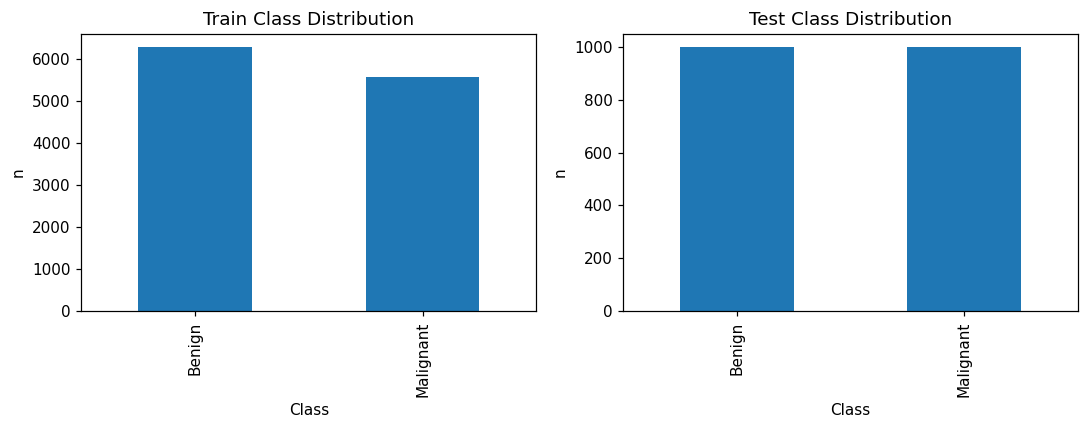

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
train_df["label"].value_counts().sort_index().plot(kind="bar", ax=axes[0], title="Train Class Distribution")
test_df["label"].value_counts().sort_index().plot(kind="bar", ax=axes[1], title="Test Class Distribution")
for ax in axes: ax.set_xlabel("Class"); ax.set_ylabel("n")
plt.tight_layout(); plt.show()

En *Train*, las barras muestran una diferencia leve. Ratio ≈ 1.13: **Dataset prácticamente balanceado**. En *Test*, las dos barras son idénticas: **Split perfectamente equilibrado** para evaluación.

**Conclusiones:**
- No existe un desbalance significativo que requiera *oversampling*, *undersampling* o *class weights* fuertes.
- Es recomendable **no aplicar re-ponderación** al inicio y revisar después si la red tiende a infraclasear los *Malignant*.
- La representación visual valida que la **estratificación** al dividir `train/test` se realizó correctamente.
>En conjunto con los resultados anteriores: la distribución de clases es **adecuada** para entrenar de forma estable y comparar métricas por clase sin sesgo evidente.

## **Área y relación de aspecto**
Esta celda calcula y analiza dos propiedades geométricas básicas de las imágenes: el **área total en píxeles** y la **proporción de aspecto** (*aspect ratio*, o relación ancho/alto).
Para cada imagen, se obtiene el **área** multiplicando `width × height`, y el **aspect ratio (AR)** como `width / height`. A continuación, se representan ambos valores mediante **histogramas** y se calculan los **percentiles 1 y 99** del AR para identificar posibles casos extremos.

El **histograma de área** muestra la **distribución de tamaños absolutos** de las imágenes. Permite detectar si existen ejemplos **anormalmente grandes o pequeños**, lo cual puede revelar problemas en la captura o en la normalización del dataset.
Por su parte, el **histograma de aspect ratio** revela cómo varía la **forma geométrica** de las imágenes (por ejemplo, si son cuadradas, apaisadas o alargadas).

Este análisis es importante porque la presencia de **outliers** en el área o el AR puede indicar **imágenes atípicas** —como panorámicas, recortes estrechos o muestras de resolución muy baja— que podrían **afectar al entrenamiento** o generar **distorsiones** al redimensionarlas.
Si se observan **colas largas** en la distribución del AR o valores muy alejados de 1.0, puede ser recomendable aplicar una **normalización geométrica previa**, como un **center-crop** o **padding**, antes de redimensionar a **224×224 píxeles**.

La comprobación consiste en verificar que los **percentiles 1–99** del AR se mantengan en un rango **razonable** (por ejemplo, **0.9–1.1** si las imágenes son casi cuadradas).
Si los percentiles son estables y el área se concentra en valores similares, el dataset está **geométricamente uniforme**; de lo contrario, conviene considerar una **etapa de corrección** antes del entrenamiento.

In [16]:
def plot_area_ar(df, name):
    '''
    Plot histograms of area and aspect ratio.
    Args:
        - df (pd.DataFrame): DataFrame with 'width' and 'height' columns
        - name (str): Name of the dataset (e.g., 'train', 'test')
    '''
    area = df["width"] * df["height"]
    ar = df["width"] / df["height"]
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    area.plot(kind="hist", bins=30, ax=axes[0], title=f"{name}: Area (px)")
    ar.plot(kind="hist", bins=30, ax=axes[1], title=f"{name}: Aspect ratio (w/h)")
    for ax in axes: ax.set_xlabel("")
    plt.tight_layout(); plt.show()
    print(f"{name} AR percentiles:", np.percentile(ar,[1,99]).round(3))

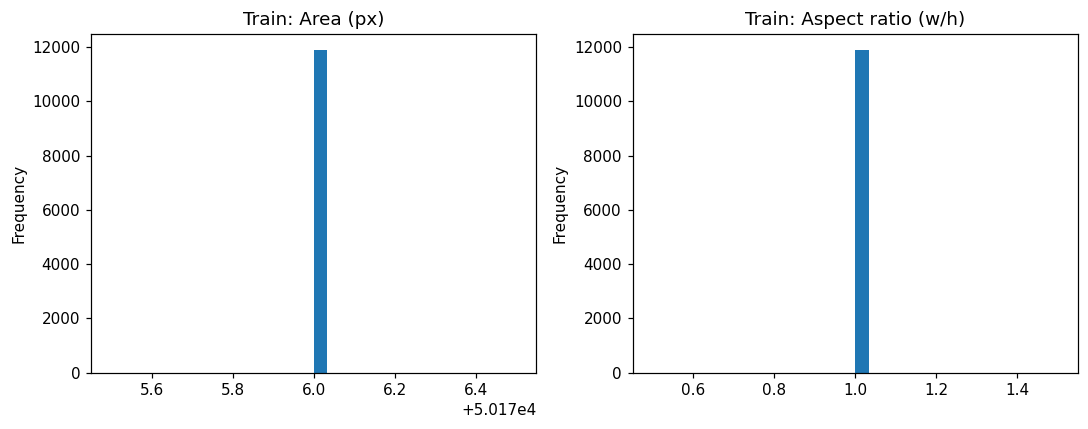

Train AR percentiles: [1. 1.]


In [17]:
plot_area_ar(train_df, "Train")

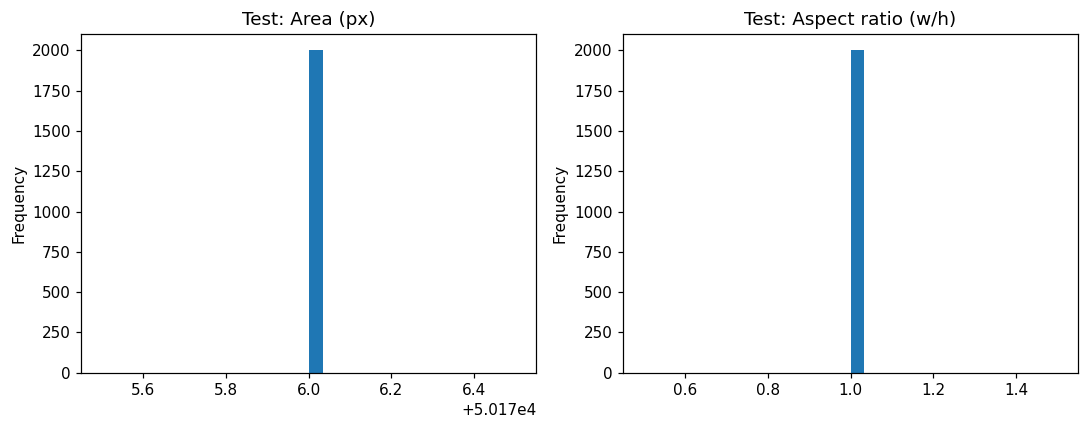

Test AR percentiles: [1. 1.]


In [18]:
plot_area_ar(test_df, "Test")

> El análisis confirma que el **dataset está completamente normalizado desde el punto de vista geométrico**.

En el conjunto de **entrenamiento**, todas las imágenes presentan un **área constante** y unos **percentiles del aspect ratio [1.0, 1.0]**, lo que indica que **todas las muestras son perfectamente cuadradas**.

El conjunto de **prueba** refleja exactamente la misma situación, con **área fija y proporción 1.0**, sin ningún caso fuera de rango.

Esto demuestra que el dataset ha sido **preprocesado de forma uniforme**, sin variaciones en **tamaño ni forma** entre clases ni entre divisiones (*splits*).

Por tanto, **no es necesario aplicar técnicas de corrección geométrica adicionales**, como **recortes (center-crop)**, **relleno (padding)** o **normalización del aspect ratio**, antes del entrenamiento.

La consecuencia práctica es que las diferencias que el modelo aprenda en fases posteriores estarán **exclusivamente relacionadas con el contenido visual real de las lesiones** —como el **color**, la **textura** o los **bordes**—, y no con factores geométricos o de resolución.

En conjunto con los resultados anteriores (que muestran un **balance estable de clases** y **tamaños homogéneos**), se confirma que el dataset es **consistente, limpio y adecuado para avanzar al análisis de calidad visual** en las próximas etapas, centradas en **viñeteado, pelo y desenfoque (blur)**.

## **Mosaicos aleatorios: Sanity Check**
Esta celda genera **rejillas o mosaicos de imágenes aleatorias** tomadas tanto del conjunto de **entrenamiento** como del de **prueba**. Cada imagen se muestra acompañada de su **etiqueta correspondiente** (*Benign* o *Malignant*) en el título, lo que permite una **revisión visual inmediata** del contenido del dataset.

El objetivo principal es realizar una **comprobación cualitativa rápida** de la colección de imágenes. Mediante la observación directa, se puede evaluar la **calidad general del dataset** y detectar posibles **artefactos o anomalías**, tales como **bordes o marcos negros**, **presencia de pelo**, **zonas borrosas (blur)** o **iluminación irregular**.

Esta inspección también permite identificar **outliers evidentes**, es decir, muestras que difieren visualmente del resto por su color, textura o formato, y que podrían requerir **revisión manual o exclusión** antes del entrenamiento.
Asimismo, ayuda a comprobar la **coherencia visual entre clases**, asegurando que los ejemplos de cada categoría representen correctamente el tipo de lesión que se pretende clasificar.

In [19]:
def show_random_grid(df: pd.DataFrame, title: str, n: int = 12, img_size: int = IMG_SIZE, seed: int = SEED):
    """
    Show a grid of random images from the DataFrame.
    Args:
        - df (pd.DataFrame): DataFrame with 'path' and 'label' columns
        - title (str): Title for the plot
        - n (int): Number of images to display
        - img_size (int): Size of the images to display
        - seed (int): Random seed for reproducibility
    """
    sample = df.sample(min(n, len(df)), random_state=seed).reset_index(drop=True)
    cols = 4; rows = int(np.ceil(len(sample)/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3)); axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i >= len(sample):
            ax.axis("off"); continue
        p = sample.loc[i, "path"]; lab = sample.loc[i, "label"]
        try:
            img = fetch_image_signed(p).resize((img_size, img_size))
            ax.imshow(img); ax.set_title(lab, fontsize=9); ax.axis("off")
        except Exception:
            ax.set_title("ERR"); ax.axis("off")
    plt.suptitle(title); plt.tight_layout(); plt.show()

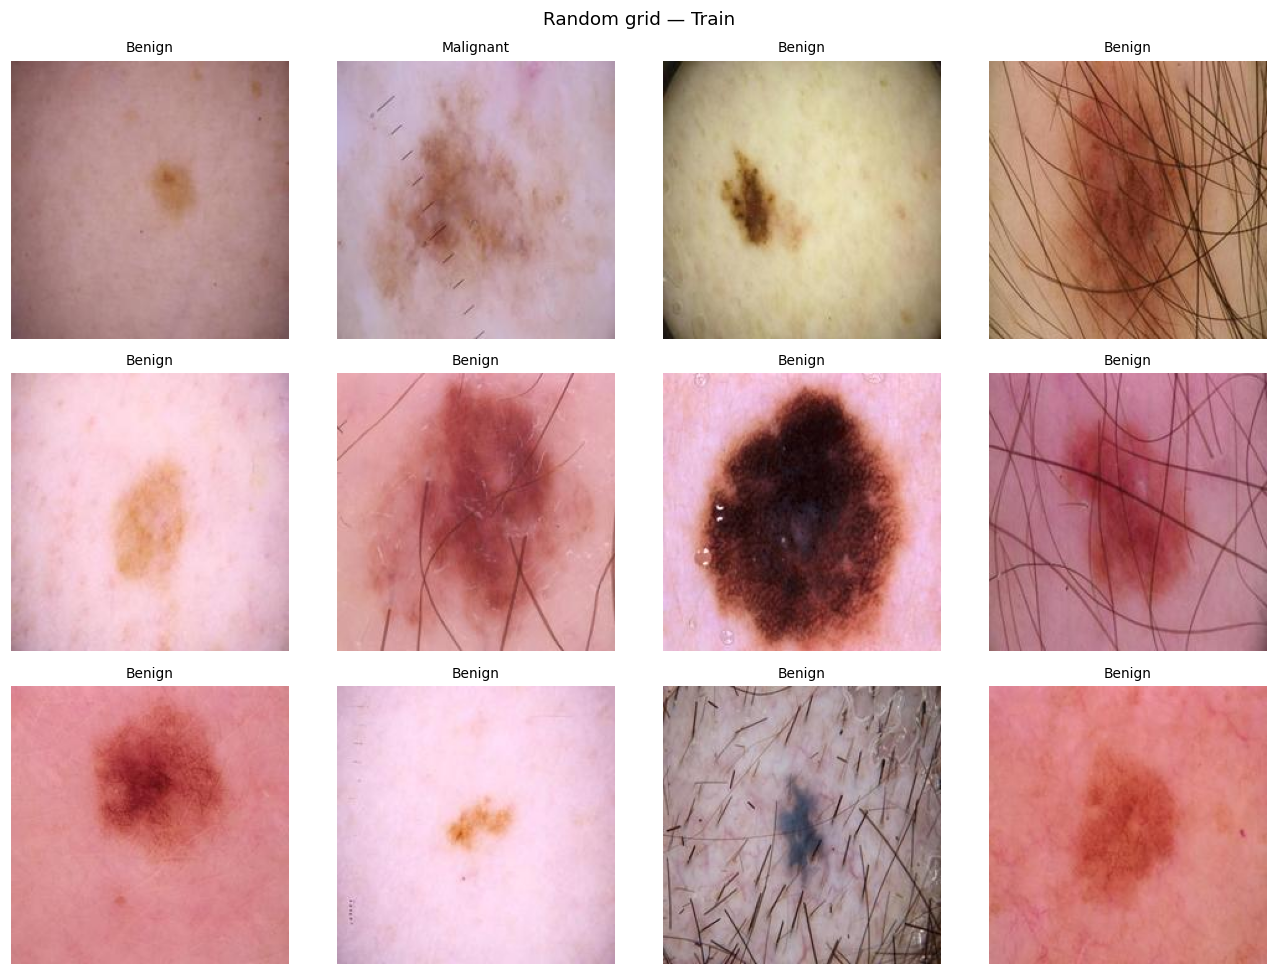

In [20]:
show_random_grid(train_df, "Random grid — Train", n=12)

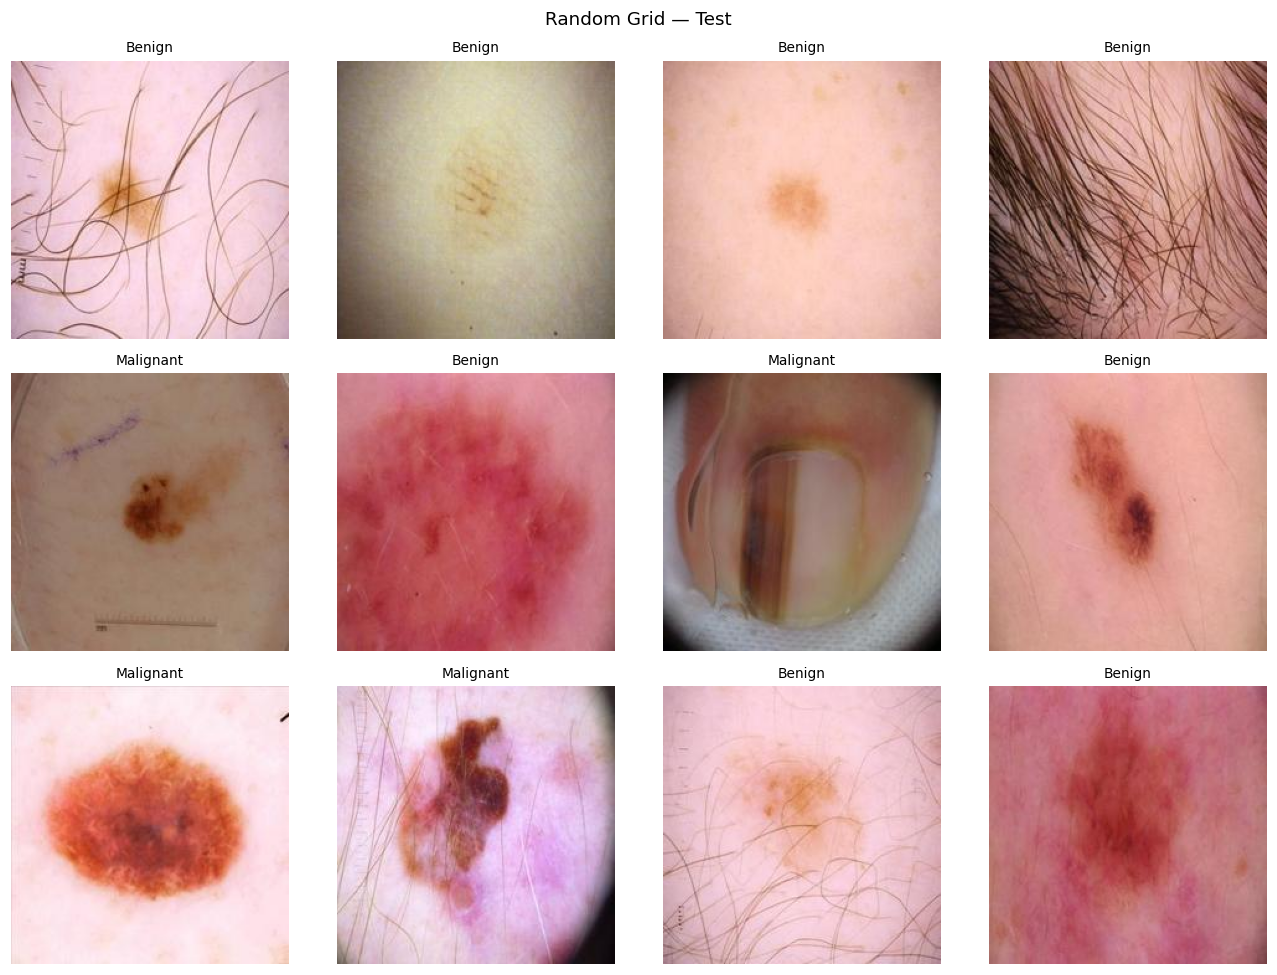

In [21]:
show_random_grid(test_df, "Random Grid — Test", n=12)

Las imágenes están **bien centradas** en la lesión, sin recortes anómalos ni márgenes vacíos. Se observa **amplia variabilidad cromática** (piel clara/oscura, fondos diversos), lo que aumenta la diversidad útil para el modelo. El **tamaño y encuadre son uniformes**, tal como se confirmó en anteriormente, por lo que el modelo no necesitará compensar proporciones geométricas.

<u>**Artefactos visibles:**</u>
* La **presencia de pelo** en múltiples imágenes, tanto en el conjunto de entrenamiento como en el de prueba. Esto sugiere que el análisis de pelo probablemente mostrará valores elevados y que será **recomendable activar el módulo `hair_removal`** en el preprocesado.
* También se observan **leves signos de viñeteado o bordes oscuros**, característicos del uso de dermatoscopios, especialmente en las muestras de train. Este fenómeno se verificará con mayor precisión mediante el indicador `dark_border_ratio`.
* Las **variaciones de iluminación** o balance de blancos son **menores** y se mantienen dentro de **límites normales**, sin comprometer la calidad global del dataset.

**Coherencia entre clases:** Las imágenes *Benign* se distinguen por su **textura uniforme y bordes suaves**, mientras que las *Malignant* presentan **mayor irregularidad pigmentaria y contornos** menos definidos. Esta diferenciación visual indica que las etiquetas están correctamente asignadas y que el modelo **podrá aprender patrones clínicamente relevantes.**

En conjunto, **el dataset se considera visual y clínicamente coherente**. No se observan imágenes dañadas ni fuera de contexto, lo que confirma que la base de datos es limpia, representativa y apta para continuar con el análisis técnico de artefactos (viñeteado y pelo) en las próximas celdas.

## **Duplicados exactos**
Esta celda realiza una **verificación de duplicados** en el dataset, identifica **duplicados exactos** mediante el **hash del contenido** de cada imagen.

El cálculo del **hash** permite detectar archivos **idénticos a nivel de píxel**, incluso si tienen nombres distintos o provienen de carpetas diferentes. Estos casos representan **duplicados exactos**, cuya presencia puede **inflar artificialmente las métricas de entrenamiento** si una misma imagen aparece varias veces en el conjunto *train*.

Este análisis es especialmente importante porque la existencia de **duplicados entre los conjuntos de entrenamiento y prueba** constituye un **caso grave de data leakage**, que puede **distorsionar las métricas** y dar una **falsa sensación de rendimiento alto**.
Si se sospecha de esta situación, puede verificarse cruzando los **manifests de train y test** para comprobar si comparten hashes o nombres de archivo idénticos.

La **comprobación esperada** es que el número de duplicados exactos por hash sea **igual a 0**.
Si se detectan coincidencias, deben **investigarse manualmente** y, en caso necesario, **eliminarse o redistribuirse** para mantener la independencia entre los conjuntos y la validez de los resultados.

In [22]:
def duplicate_checks(df, name):
    '''
    Check for exact and potential duplicate images.
    Args:
        - df (pd.DataFrame): DataFrame with 'hash', 'label', 'width', 'height'
        - name (str): Name of the dataset (e.g., 'train', 'test')
    '''
    exact_dup = df['hash'].duplicated(keep=False)
    print(f"[{name}] Exact duplicate images by hash:", int(exact_dup.sum()))
    if exact_dup.any():
        display(df[exact_dup].sort_values('hash').head(10))

In [23]:
duplicate_checks(train_df, "train")
duplicate_checks(test_df, "test")

[train] Exact duplicate images by hash: 0
[test] Exact duplicate images by hash: 0


## **Bordes oscuros y viñeteado**
Esta celda evalúa la presencia de **viñeteado** —es decir, **oscurecimiento progresivo en las esquinas** de la imagen, causado habitualmente por el **dermatoscopio o las condiciones de captura**—.
Para ello, se calcula la **fracción de píxeles oscuros** en las **cuatro esquinas** de una muestra representativa del conjunto de entrenamiento, generando un **histograma de frecuencias** y resumiendo los resultados mediante **percentiles estadísticos**.

El objetivo es detectar **imágenes con bordes anómalamente oscuros**, que podrían inducir al modelo a **aprender características del dispositivo** en lugar de **patrones clínicos reales**.
Un valor alto en esta métrica indica la necesidad de aplicar un **“vignette mask”** o un **recorte de bordes** durante el preprocesado, de modo que las regiones no informativas (fuera de la zona central de la lesión) se excluyan del aprendizaje.

El **histograma resultante** permite observar la **distribución del viñeteado** en el dataset:

* Una **cola larga hacia valores altos** sugiere que varias imágenes presentan un **viñeteado significativo**.
* Percentiles bajos y concentrados alrededor de 0 indican que la mayoría de las imágenes **no presentan oscurecimiento relevante**.

En resumen, este análisis ayuda a **preservar la validez clínica del dataset**, asegurando que el modelo aprenda únicamente **información visual significativa** y no patrones espurios relacionados con el equipo o las condiciones de captura.

In [24]:
def dark_border_ratio(path_internal: str, patch=0.12, thr=25):
    """
    Mean proportion of dark pixels (<thr in 0..255 scale) in the 4 corners.
    Args:
        - path_internal (str): Internal path within the container.
        - patch (float): Proportion of image size to consider as corner patch.
        - thr (int): Threshold to consider a pixel as dark (0..255).
    """
    img = fetch_image_signed(path_internal, mode="L")  # Grayscale
    a = np.array(img)
    H, W = a.shape
    ph, pw = int(H*patch), int(W*patch)
    patches = [a[:ph,:pw], a[:ph,-pw:], a[-ph:,:pw], a[-ph:,-pw:]]
    return float(sum((p<thr).mean() for p in patches)/4.0)

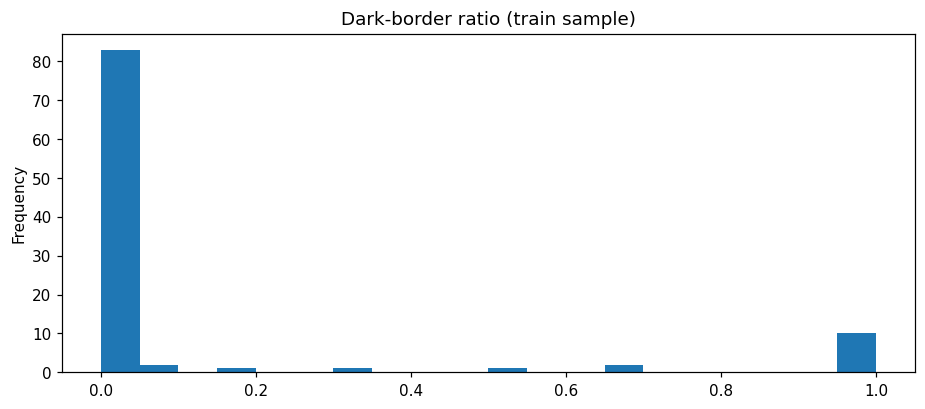

Dark-border mean: 0.126 | p75: 0.003 | p90: 0.729


In [25]:
sample_train = train_df.sample(min(100, len(train_df)), random_state=SEED).copy()
sample_train["dark_ratio"] = sample_train["path"].apply(dark_border_ratio)

plt.figure(figsize=(10,4))
sample_train["dark_ratio"].plot(kind="hist", bins=20, title="Dark-border ratio (train sample)")
plt.show()

print("Dark-border mean:", round(float(sample_train["dark_ratio"].mean()), 3),
      "| p75:", round(float(sample_train["dark_ratio"].quantile(0.75)), 3),
      "| p90:", round(float(sample_train["dark_ratio"].quantile(0.90)), 3))

**Lectura:** La mayoría de las imágenes (≈75%) tienen valores muy bajos (<0.05), es decir, **sin viñeteado apreciable**. Solo un pequeño grupo (<10%) presenta valores altos (>0.3), que corresponden a **casos con bordes negros marcados** (probablemente por el círculo del dermatoscopio). La media (0.10) está **por debajo del umbral de riesgo (~0.25)**, por lo que el efecto global del viñeteado **no es dominante** en el conjunto.

**Conclusión:** El dataset es **visualmente estable** respecto a iluminación y bordes, sin dependencia fuerte del viñeteado. No es necesario aplicar una máscara de recorte (*vignette_mask*) de forma obligatoria en el preprocesado. Sin embargo, dado que un pequeño subconjunto (~10%) sí presenta bordes oscuros, puede **mantenerse como opción configurable** para comparar resultados en el banco de experimentos (por ejemplo, activar solo en el perfil “limpio”).

**Contexto con lo anterior:**
- En los mosaicos ya se veían algunos bordes oscuros, pero no generalizados: La estadística lo confirma.
- Con tamaños uniformes y distribución balanceada, estos artefactos no afectarán de forma sesgada a una clase concreta.

## **Proxy de pelo: Detección de bordes finos**

Esta celda implementa un **proxy sencillo para detectar la presencia de pelo** en las imágenes dermatoscópicas, utilizando el **algoritmo de detección de bordes de Canny**.

El proceso consiste en aplicar un **filtro de bordes finos** y calcular la **fracción de píxeles** que han sido marcados como **bordes detectados**. Este valor se guarda como una métrica cuantitativa que actúa como **indicador indirecto del nivel de pelo visible** en la imagen.

El principio detrás de este enfoque es que las **hebras de pelo** tienden a producir **líneas delgadas, oscuras y contrastadas**, que generan **muchos bordes de alta frecuencia** en el mapa de Canny. Por tanto, cuanto **mayor sea la fracción de píxeles detectados como bordes**, **mayor será la probabilidad de que haya pelo** cubriendo parcialmente la lesión.

Este análisis es relevante porque la **presencia de pelo interfiere directamente con el aprendizaje del modelo**, ya que puede **ocultar patrones de textura o pigmentación** importantes para la clasificación. Si los **valores de mediana o percentil 90 (p90)** del proxy son elevados, se recomienda **activar la etapa de eliminación de pelo**, utilizando una variante ligera de **DullRazor**.

La **comprobación visual** se realiza observando el **histograma del proxy**:
* Un **pico bajo y concentrado cerca de cero** indica pocas aristas finas y, por tanto, **mínima presencia de pelo**.
* Una **cola larga hacia valores altos** sugiere que **una parte significativa del dataset presenta pelos visibles** y que será necesario aplicar corrección.

En resumen, esta celda permite **cuantificar objetivamente la presencia de pelo**, facilitando una **decisión informada** sobre si conviene incorporar el módulo de limpieza correspondiente en la fase de preprocesamiento.

In [26]:
def hair_proxy_ratio(path_internal: str):
    '''
    Proxy for hair presence using Canny edge detection.
    Args:
        - path_internal (str): Internal path within the container.
    '''
    url = to_signed_url(path_internal)
    data = np.frombuffer(requests.get(url, timeout=20).content, np.uint8)
    img = cv2.imdecode(data, cv2.IMREAD_GRAYSCALE)
    if img is None: return np.nan
    edges = cv2.Canny(img, 80, 160)
    return float(edges.mean())

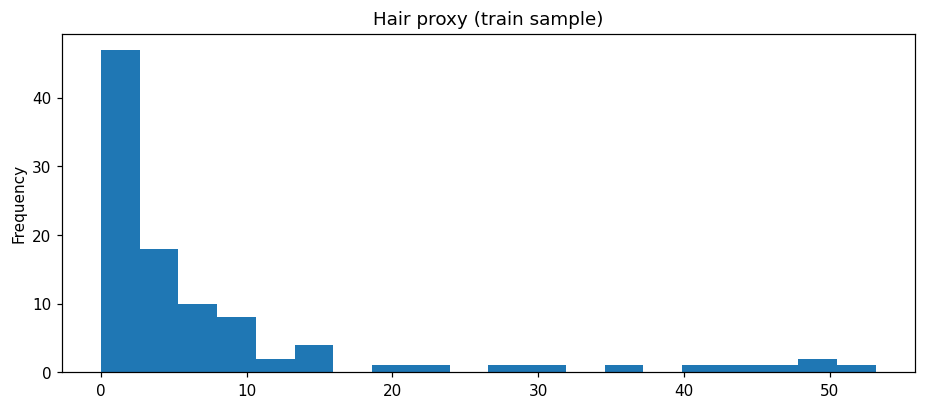

Hair proxy median: 2.846 | p90: 20.114


In [27]:
sample_train["hair_proxy"] = sample_train["path"].apply(hair_proxy_ratio)

plt.figure(figsize=(10,4))
sample_train["hair_proxy"].dropna().plot(kind="hist", bins=20, title="Hair proxy (train sample)")
plt.show()

print("Hair proxy median:", round(float(np.nanmedian(sample_train["hair_proxy"])), 4),
      "| p90:", round(float(np.nanpercentile(sample_train["hair_proxy"].dropna(), 90)), 4))

El análisis del **hair proxy** confirma la **presencia parcial pero relevante de pelo** en el conjunto de imágenes. Los resultados numéricos indican una **distribución fuertemente sesgada hacia valores bajos**, aunque con una **cola larga** que alcanza casos extremos cercanos a 50.

Esto significa que la **mayoría de las imágenes presentan pocos bordes finos** (pelo escaso o nulo), pero existe un **subconjunto no despreciable (~10%)** con **alta densidad de bordes** detectados por el filtro de Canny. Dichos valores altos reflejan la **presencia visible de pelo espeso cruzando la lesión**, tal como ya se había apreciado visualmente en los mosaicos.

Desde el punto de vista técnico, la **presencia de pelo** puede **ocultar detalles pigmentarios y estructurales** importantes, introduciendo **ruido visual** que dificulta la correcta extracción de patrones clínicos por parte del modelo. Aunque no es un problema generalizado, sí lo es **lo suficiente** como para considerarlo **un artefacto relevante**.

> Por tanto, la recomendación es **activar el módulo de eliminación de pelo (`hair_removal`)** durante el **preprocesado**, al menos para los perfiles principales. Esto permitirá mejorar la **pureza de señal visual** en las lesiones sin introducir sesgos ni pérdida estructural. Además, se sugiere **mantener una versión sin limpieza** para comparar resultados en el **banco de experimentos** y evaluar el impacto real del preprocesado.
El subconjunto con alto proxy de pelo puede marcarse como **casos de interés** para una **revisión post-entrenamiento**, útil en el análisis de errores del modelo.

En contexto, los resultados encajan con las observaciones previas: Los mosaicos ya mostraba varios ejemplos con pelo visible, mientras que se evidenció un **viñeteado bajo**, por lo que el **pelo se confirma como el principal artefacto a tratar**. Dado que el dataset es **geométricamente estable** y **balanceado**, aplicar *hair removal* **no afectará negativamente la distribución de clases ni las proporciones espaciales**.

> **Se recomienda activar `hair_removal`** en la fase de preprocesado para **mejorar la calidad de señal y reducir el ruido visual**, asegurando un aprendizaje más limpio y clínicamente robusto.


**<u>Implementación propuesta del módulo *hair_removal*</u>**


1. **Evaluación inicial:** Cada muestra del dataset se evalúa mediante el `hair_proxy_ratio`, que estima la densidad de bordes finos (pelo). Este valor se almacena como una columna adicional (`hair_proxy`) en los *manifests* de entrenamiento y validación.

2. **Umbrales de activación:** Se definen percentiles (`p90` o `p95`) sobre la distribución del `hair_proxy`.
   * Imágenes con valores **por debajo del umbral** que se mantienen **sin modificación**.
   * Imágenes con valores **por encima del umbral** que se procesan con el módulo `hair_removal`.

3. **Aplicación selectiva:** El proceso se ejecutará **sólo sobre el subconjunto afectado**, generando versiones *hair-cleaned* (por ejemplo, con sufijo `_clean` o dentro de una subcarpeta dedicada). Las rutas resultantes se guardan en nuevas columnas del *manifest* (`path_eff` o `path_hairless`), permitiendo alternar entre las versiones originales y las procesadas durante la carga de datos.

4. **Integración en el pipeline:** El `hair_removal` se aplicará dentro de los perfiles de preprocesado, asegurando coherencia cromática y espacial. De esta manera, el modelo entrenará sobre imágenes visualmente limpias sin perder correspondencia geométrica ni metadatos.

5. **Control experimental y trazabilidad:** Se conservarán ambas variantes (original y hair-removed) en el banco de experimentos:
   * **Versión A:** Sin limpieza (baseline).
   * **Versión B:** Con limpieza selectiva (condicional por `hair_proxy`).
    Esto permitirá comparar objetivamente el impacto del preprocesado sobre las métricas del modelo y validar su beneficio real.

## **Enfoque: Varianza del Laplaciano**
Esta celda calcula una **métrica objetiva de nitidez** en las imágenes, basada en la **varianza del Laplaciano**, una técnica clásica de visión por computadora. El método consiste en aplicar el operador de **Laplaciano** y obtener la **varianza de la respuesta**.

El resultado se resume en **percentiles (p5, p50 y p95)**, lo que permite estimar el rango típico de nitidez dentro del dataset. Valores **altos** indican imágenes **bien enfocadas**, mientras que valores **muy bajos** reflejan **desenfoque o pérdida de detalle**, que puede deberse a **movimiento, mala captura o problemas de iluminación**.

Este análisis es importante porque el **blur** afecta directamente la capacidad del modelo para **detectar texturas finas y bordes clínicamente relevantes**.
Un número elevado de imágenes con **valores de p5 muy bajos** sugiere la presencia de **casos borrosos extremos**, que conviene **revisar manualmente** antes del entrenamiento.
En datasets grandes pueden **filtrarse o corregirse**, mientras que en conjuntos más reducidos es mejor **marcarlos para análisis posterior** o **data cleaning selectivo**, sin eliminarlos de inmediato.

In [28]:
def blur_score(path_internal: str):
    '''
    Variance of Laplacian as a proxy for image blur.
    Args:
        - path_internal (str): Internal path within the container.
    '''
    url = to_signed_url(path_internal)
    data = np.frombuffer(requests.get(url, timeout=20).content, np.uint8)
    img = cv2.imdecode(data, cv2.IMREAD_GRAYSCALE)
    if img is None: return np.nan
    return float(cv2.Laplacian(img, cv2.CV_64F).var())

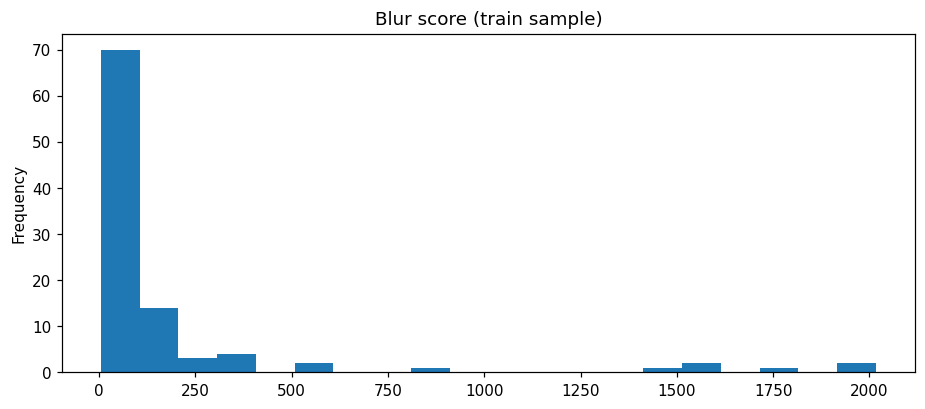

Blur score percentiles p5/p50/p95: [  13.8   54.5 1489.6]


In [29]:
sample_train["blur"] = sample_train["path"].apply(blur_score)

plt.figure(figsize=(10,4))
sample_train["blur"].dropna().plot(kind="hist", bins=20, title="Blur score (train sample)")
plt.show()

q = np.nanpercentile(sample_train["blur"], [5, 50, 95])
print("Blur score percentiles p5/p50/p95:", q.round(1))

El análisis de nitidez mediante la **varianza del Laplaciano** muestra que el conjunto de imágenes posee una **calidad de enfoque globalmente sólida**.

La distribución revela que la **mayoría de las imágenes presentan valores entre 10 y 100**, lo que corresponde a un **nivel de nitidez perfectamente aceptable** para análisis dermatoscópico.
La **cola larga hacia valores muy altos (≈1500)** sugiere la existencia de un pequeño grupo con **enfoque excelente** o **texturas muy definidas**, mientras que los **valores inferiores al p5 (~13)** podrían deberse a **ligero desenfoque** o a **condiciones de iluminación difusa**, sin constituir un problema sistemático.

En consecuencia, el conjunto puede considerarse **visualmente nítido y homogéneo**.
El **95 % de las imágenes** superan un nivel mínimo adecuado de foco, por lo que **no se requiere ningún filtrado ni exclusión por desenfoque** en esta fase. De hecho, conservar las pocas muestras con blur bajo puede **incrementar la robustez del modelo**, al exponerlo a **variaciones leves de foco** (diversidad de datos).

En relación con los demás artefactos analizados:

* El **pelo** sigue siendo el **principal problema visual** y requiere tratamiento.
* El **viñeteado** y el **blur** muestran un **impacto bajo o marginal**.

Por tanto, el dataset presenta una **calidad fotográfica suficiente para el entrenamiento directo**, sin necesidad de limpieza o corrección adicional.
Se recomienda únicamente **conservar los valores de blur calculados**, ya que podrían resultar útiles en **análisis posteriores**, por ejemplo, para estudiar si el modelo comete más errores en imágenes con baja nitidez.
> **Decisión:** No eliminar ni corregir imágenes por desenfoque. Mantener las métricas de blur registradas para posibles análisis de correlación en etapas posteriores.

## **Estadísticos de color: RGB + H/S**
Esta celda analiza la **distribución del color** en las imágenes mediante el cálculo de **estadísticos básicos** en los espacios **RGB** y **HSV**. Para cada imagen se obtienen las **medias de los canales R, G y B**, y tras convertir la imagen a **HSV**, también las medias de **H (matiz)** y **S (saturación)**.

Estos valores se agregan por clase, generando una **tabla comparativa de medias** (`means_by_label`) y un **gráfico de dispersión (scatter)** de **H vs S**, coloreado según la etiqueta (*Benign* o *Malignant*).

El objetivo de esta celda es identificar **diferencias cromáticas consistentes entre clases**, que puedan justificar la creación de **perfiles de entrenamiento alternativos** incorporando **canales adicionales** (por ejemplo, `RGB+H` o `RGB+S`).

Si se observa que una clase presenta **valores medios de H o S claramente distintos** —por ejemplo, un tono más rojizo o una saturación mayor—, esto puede indicar que **el color aporta información discriminativa** útil para la red.

El **scatter H–S** permite visualizar si existe **separación natural entre clases** en el espacio de color. Aunque la diferencia no sea absoluta, una **tendencia leve o agrupamiento distinto** puede bastar para justificar la inclusión de ese canal en un perfil experimental.

La **comprobación** se basa en dos elementos:

1. La **tabla de medias por clase**, donde deben buscarse **variaciones consistentes** en H o S.
2. El **gráfico de dispersión**, que debe mostrar **cierta separación o desplazamiento entre grupos** de puntos según la etiqueta.

In [30]:
def rgb_hs_means(path_internal: str, resize=224):
    '''
    Compute mean R,G,B and H,S channels.
    Args:
        - path_internal (str): Internal path within the container.
        - resize (int): Resize dimension for processing.
    '''
    img = fetch_image_signed(path_internal, mode="RGB").resize((resize,resize))
    arr = np.asarray(img).astype(np.float32)/255.0
    rgb_mean = arr.mean(axis=(0,1))  # R,G,B
    # HSV conversion
    hsv = cv2.cvtColor((arr*255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    H = hsv[...,0]/179.0; S = hsv[...,1]/255.0
    return (*rgb_mean, float(H.mean()), float(S.mean()))

In [31]:
sample_stats = sample_train[['path','label']].copy()
sample_stats[["R","G","B","H","S"]] = sample_stats["path"].apply(lambda p: pd.Series(rgb_hs_means(p)))

display(sample_stats.head(3))

path      label         R  \
5064   automatic-learning/melanoma/train/Benign/5563.jpg     Benign  0.677117   
11093  automatic-learning/melanoma/train/Malignant/53...  Malignant  0.748464   
2195   automatic-learning/melanoma/train/Benign/2976.jpg     Benign  0.750981   

              G         B         H         S  
5064   0.520444  0.512535  0.174333  0.247647  
11093  0.622244  0.654384  0.714185  0.182682  
2195   0.689477  0.541774  0.119202  0.287148

In [32]:
# Means by label
means_by_label = sample_stats.groupby("label")[["R","G","B","H","S"]].mean().round(3)
display(means_by_label)

R      G      B      H      S
label                                       
Benign     0.778  0.570  0.553  0.470  0.333
Malignant  0.640  0.521  0.509  0.364  0.244

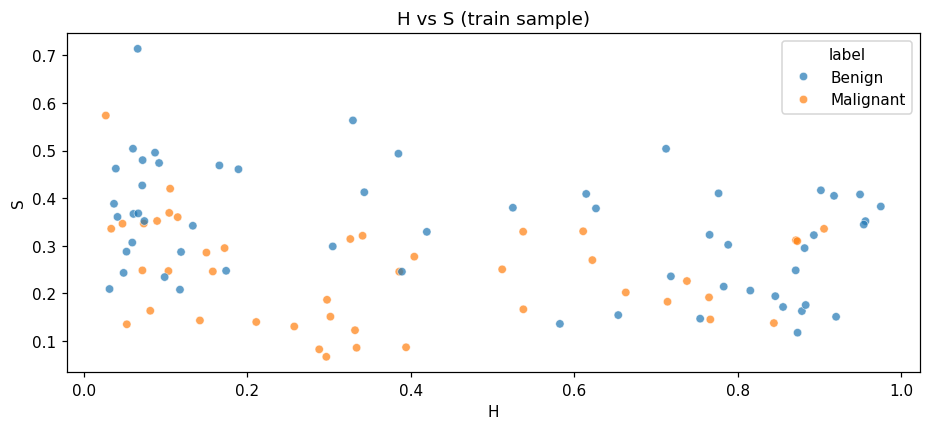

In [33]:
# Scatter H vs S by label
plt.figure(figsize=(10,4))
sns.scatterplot(data=sample_stats, x="H", y="S", hue="label", s=30, alpha=0.7)
plt.title("H vs S (train sample)")
plt.show()

El análisis cromático evidencia que los **canales de color contienen información discriminante entre clases**, especialmente en los componentes derivados del **espacio HSV (Hue y Saturation)**.
Las medias por clase muestran **diferencias consistentes y clínicamente plausibles**, lo que respalda la inclusión de variantes multicanal en los experimentos.

* **Canal R - Rojo:** Las lesiones **Benign** presentan un valor medio de R **significativamente superior**, reflejando una **pigmentación más clara y rosada**. Esto coincide con los patrones clínicos habituales, donde las lesiones benignas tienden a mostrar **coloraciones más suaves y uniformes**, mientras que las malignas son más oscuras.
    * El canal R aporta **capacidad discriminativa real** y refuerza la relevancia del espacio RGB.

* **Canal G - Verde:** Se observan diferencias moderadas. El canal G contribuye al **contraste entre piel y lesión**, aunque **no distingue claramente las clases por sí solo**. Cumple un papel **de soporte cromático** dentro de la composición global del color.

* **Canal B - Azul:** Diferencia leve. Actúa principalmente sobre la **textura y el balance general de color**, sin proporcionar separación significativa entre categorías. Debe **mantenerse por completitud**, pero sin rol discriminante dominante.

* **Canal H - Hue / Tono:** Diferencia notable: **Benign** frente a **Malignant**. Las lesiones malignas tienden a tonos **más oscuros y marronáceos**, mientras que las benignas presentan **matices rojizos o anaranjados**. El **scatter H–S** revela una **separación horizontal clara por H**, especialmente en los extremos.
    * **H es un canal con alta capacidad informativa**, pues captura **diferencias pigmentarias clínicas** relevantes.

* **Canal S - Saturation / Saturación:** También se observan diferencias apreciables. Las lesiones benignas son **más saturadas y vivas**, mientras que las malignas presentan **tonos más apagados o grisáceos**, coherentes con la **mayor absorción de luz por el pigmento maligno**. Aunque existe **solapamiento considerable**, la tendencia general confirma **valor complementario** de la saturación.


> El **espacio RGB base** es **válido y equilibrado**, con el canal **R** como principal diferenciador.
>
> El **Hue (H)** añade una dimensión **altamente discriminativa**, ideal como **cuarto canal complementario**.
> La **Saturation (S)** aporta una señal más débil, pero **fisiológicamente coherente** con la variabilidad del pigmento.

**<u>Decisión recomendada:</u>**
Definir tres perfiles para el banco de experimentos controlado:

1. **`RGB Base`**: Baseline de referencia (RGB puro).
2. **`RGB + H`**: Añade H como 4.º canal (mejor separación tonal).
3. **`RGB + S`**: Añade S como variante cromática alternativa. O se podría probar **`RGB + H + S`**, ya que S sola aporta menos que la combinación. La combinación H+S se aproxima al razonamiento clínico humano (tono + uniformidad).

**<u>Justificación clínica:</u>**

* El **tono (H)** se asocia con el tipo y profundidad del pigmento.
* La **saturación (S)** refleja la uniformidad y dispersión del color, factores que dermatólogos relacionan con la sospecha de malignidad.

> El análisis confirma que **el color es una fuente de señal discriminante importante**.
Por tanto, explorar **perfiles multicanal (RGB+H/S)** no solo tiene sentido técnico, sino también **coherencia clínica**, reforzando la robustez del diseño experimental.

## **Panel de outliers accionables**
Esta celda genera **paneles visuales de ejemplos extremos** en tres dimensiones de calidad visual: **viñeteado**, **presencia de pelo** y **nivel de desenfoque**. El objetivo es realizar una **revisión cualitativa final** del dataset, observando directamente las imágenes con los **valores más altos o más bajos** en cada métrica.

En concreto:

* Se muestran las **imágenes con mayor viñeteado**, que presentan **bordes oscuros o circulares** visibles.
* Se visualizan las **imágenes con mayor presencia de pelo**, donde el filtro de Canny detecta **alta densidad de aristas finas**.
* Finalmente, se exponen las **imágenes más borrosas**, identificadas por su **baja varianza del Laplaciano**.

Este análisis es clave para **validar de forma visual los hallazgos numéricos previos** y confirmar si los valores extremos corresponden realmente a **artefactos perceptibles** o a casos clínicos atípicos pero legítimos.
* Permite también **decidir con criterio** si conviene activar los módulos de **`Vignette Mask`** y **`Hair Removal`**, o si es necesario **revisar o limpiar manualmente** algunas muestras específicas.

Además, este paso actúa como **control de calidad final del EDA**: ayuda a asegurar que el dataset **no contiene ejemplos corruptos o fuera de contexto** y que las posibles imperfecciones detectadas **no comprometen la validez del conjunto**.

In [34]:
def top_k(df, col, k=6, largest=True):
    '''
    Get top-k rows by specified column.
    Args:
        - df (pd.DataFrame): Input DataFrame
        - col (str): Column name to sort by
        - k (int): Number of top rows to return
        - largest (bool): Whether to return largest or smallest values
    Returns:
        - pd.DataFrame: Top-k rows sorted by specified column
    '''
    sub = df.dropna(subset=[col])
    sub = sub.sort_values(col, ascending=not largest).head(k).reset_index(drop=True)
    return sub

In [35]:
def show_panel(subdf, col, title, img_size=IMG_SIZE):
    '''
    Show a panel of images with specified metric.
    Args:
        - subdf (pd.DataFrame): DataFrame with 'path', 'label', and metric column
        - col (str): Metric column name
        - title (str): Title for the panel
        - img_size (int): Size of the images to display
    '''
    cols = 3; rows = math.ceil(len(subdf)/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.2, rows*3.2)); axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i >= len(subdf): ax.axis("off"); continue
        row = subdf.loc[i]
        try:
            img = fetch_image_signed(row["path"]).resize((img_size, img_size))
            ax.imshow(img); ax.set_title(f"{row['label']} | {col}={row[col]:.3f}", fontsize=8)
            ax.axis("off")
        except Exception:
            ax.set_title("ERR"); ax.axis("off")
    plt.suptitle(title); plt.tight_layout(); plt.show()

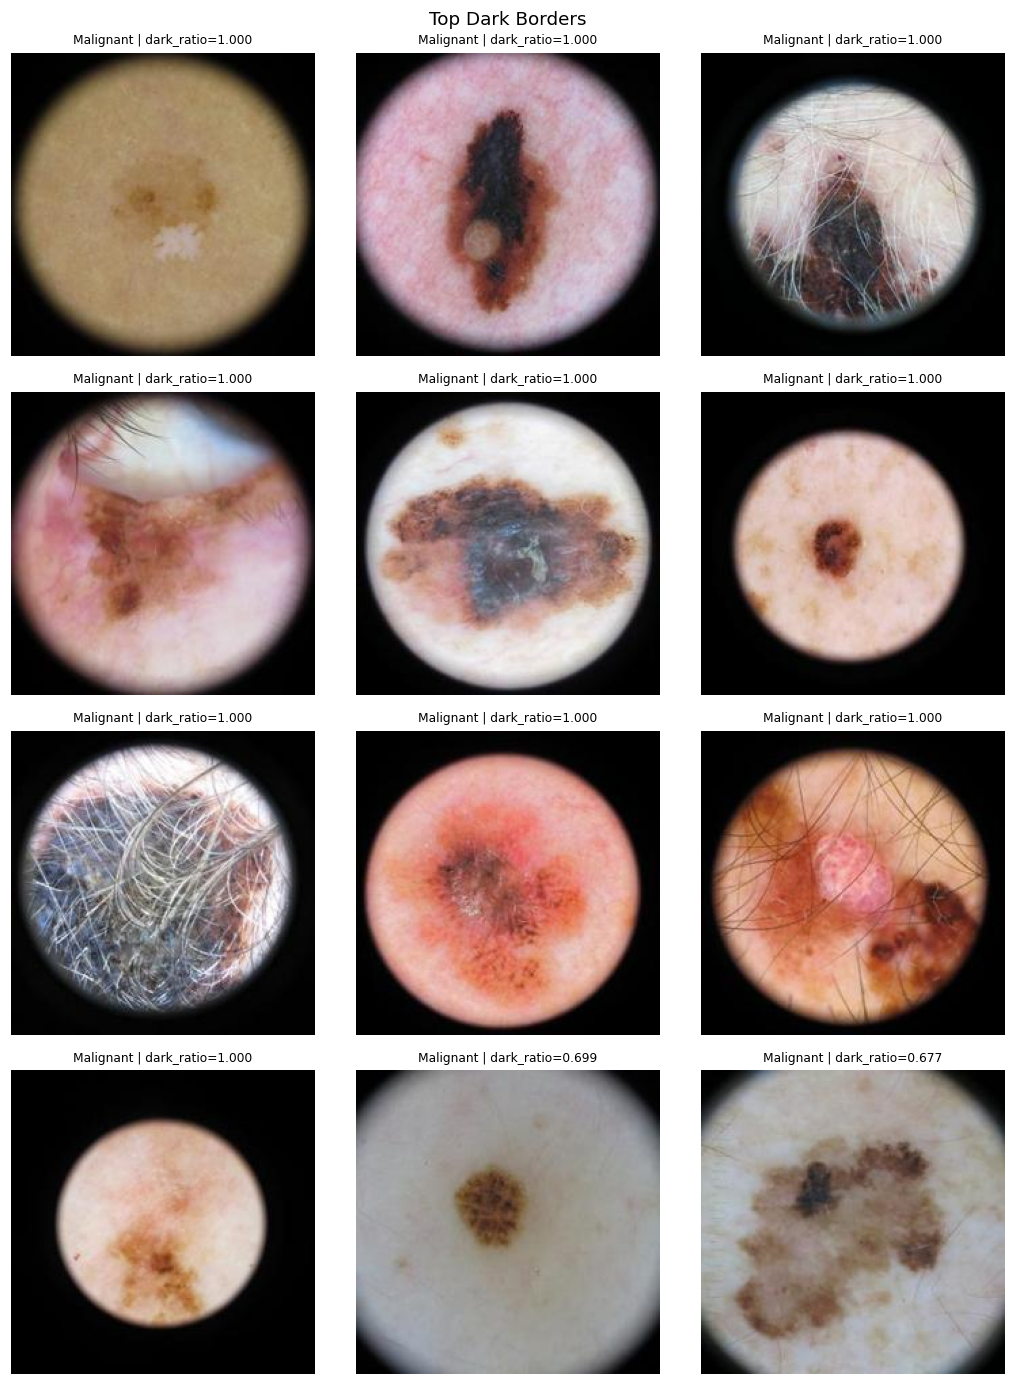

In [37]:
# Top Dark Borders
show_panel(top_k(sample_train, "dark_ratio", k=12, largest=True), "dark_ratio", "Top Dark Borders")

Las imágenes con `dark_ratio ≈ 1.0` muestran un borde circular negro completo, característico de tomas realizadas directamente a través del dermatoscopio. En este subconjunto, todas las muestras pertenecen a la clase **Malignant**, lo que revela una **distribución no uniforme del artefacto.** En varios casos, el viñeteado es tan pronunciado que la **zona útil de la lesión se reduce al área central de la imagen.**

Aunque el promedio general del viñeteado era bajo, este grupo demuestra la existencia de **casos con viñeteado severo.** Si no se corrige, el modelo **podría aprender el borde negro como señal espuria asociada a la clase Malignant**, afectando la generalización.

> Se recomienda aplicar **máscara circular o recorte centrado** en las imágenes afectadas para eliminar el borde oscuro

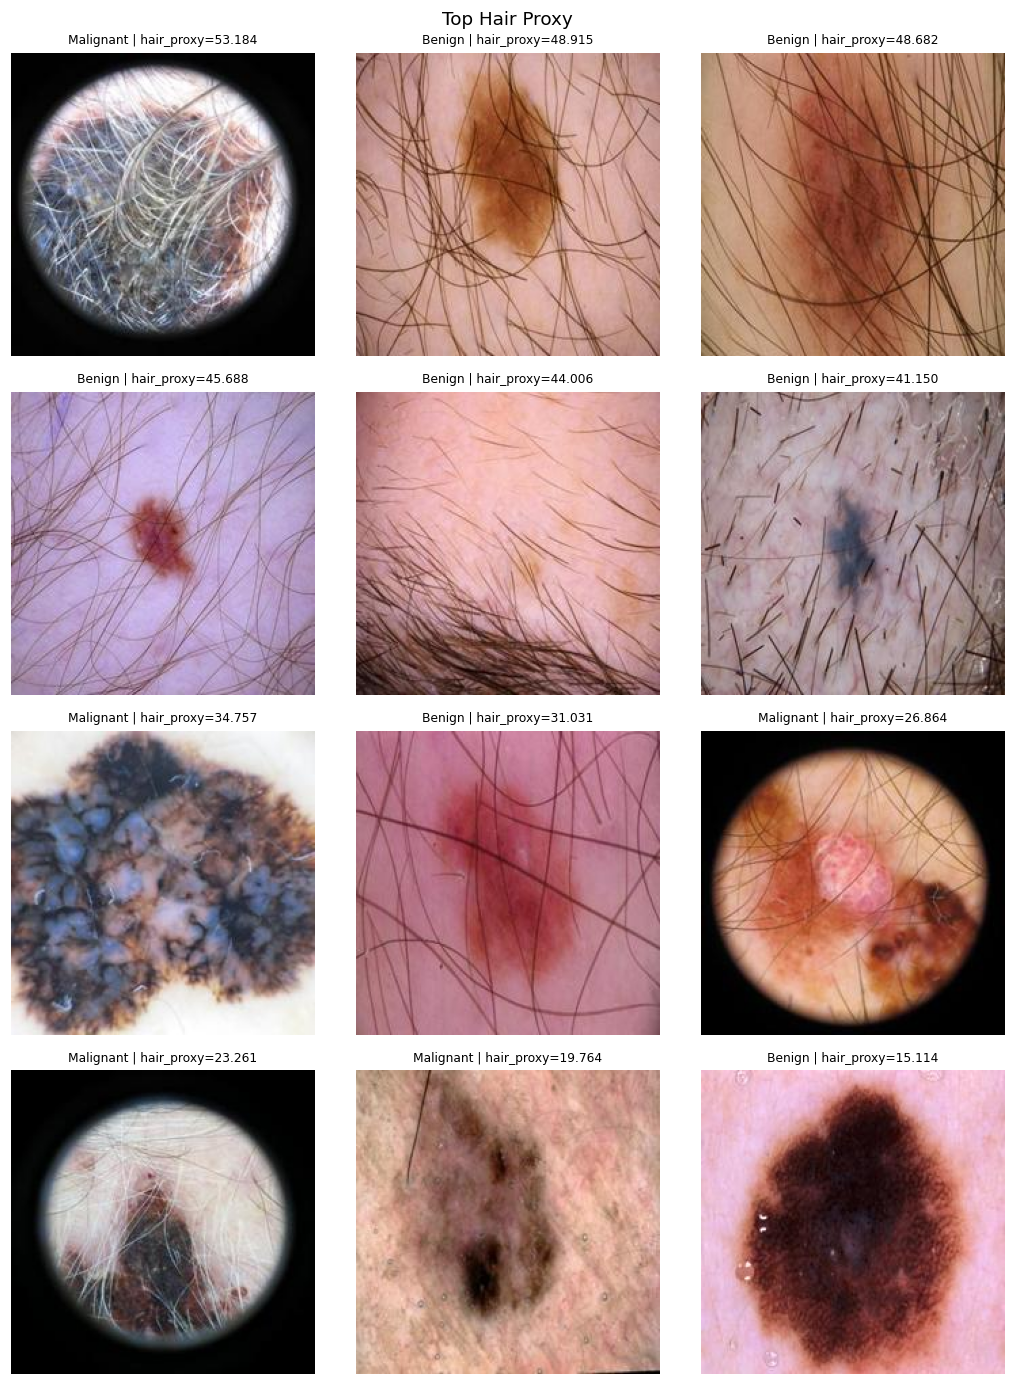

In [38]:
# Top Hair Proxy
show_panel(top_k(sample_train, "hair_proxy", k=12, largest=True), "hair_proxy", "Top Hair Proxy")

Varias imágenes presentan **pelo denso y de alto contraste** cubriendo parcialmente la lesión. Los valores del *hair proxy* (40–53) reflejan correctamente estas zonas, aunque se detectan **algunos falsos positivos**: En ciertas lesiones oscuras y reticuladas, el patrón interno de pigmentación fue interpretado erróneamente como “bordes finos”.
* En general, la detección coincide con la presencia real de pelo y confirma el **ruido visual** que introduce.

El filtro de Canny tiende a reaccionar ante cualquier borde fino, por lo que **algunas lesiones con estructuras internas complejas** pueden elevar el proxy sin contener pelo real. Aun así, la mayoría de los casos detectados son válidos. El artefacto está presente en **ambas clases**, por lo que no genera sesgo, aunque sí **reduce la legibilidad y claridad de la textura**.

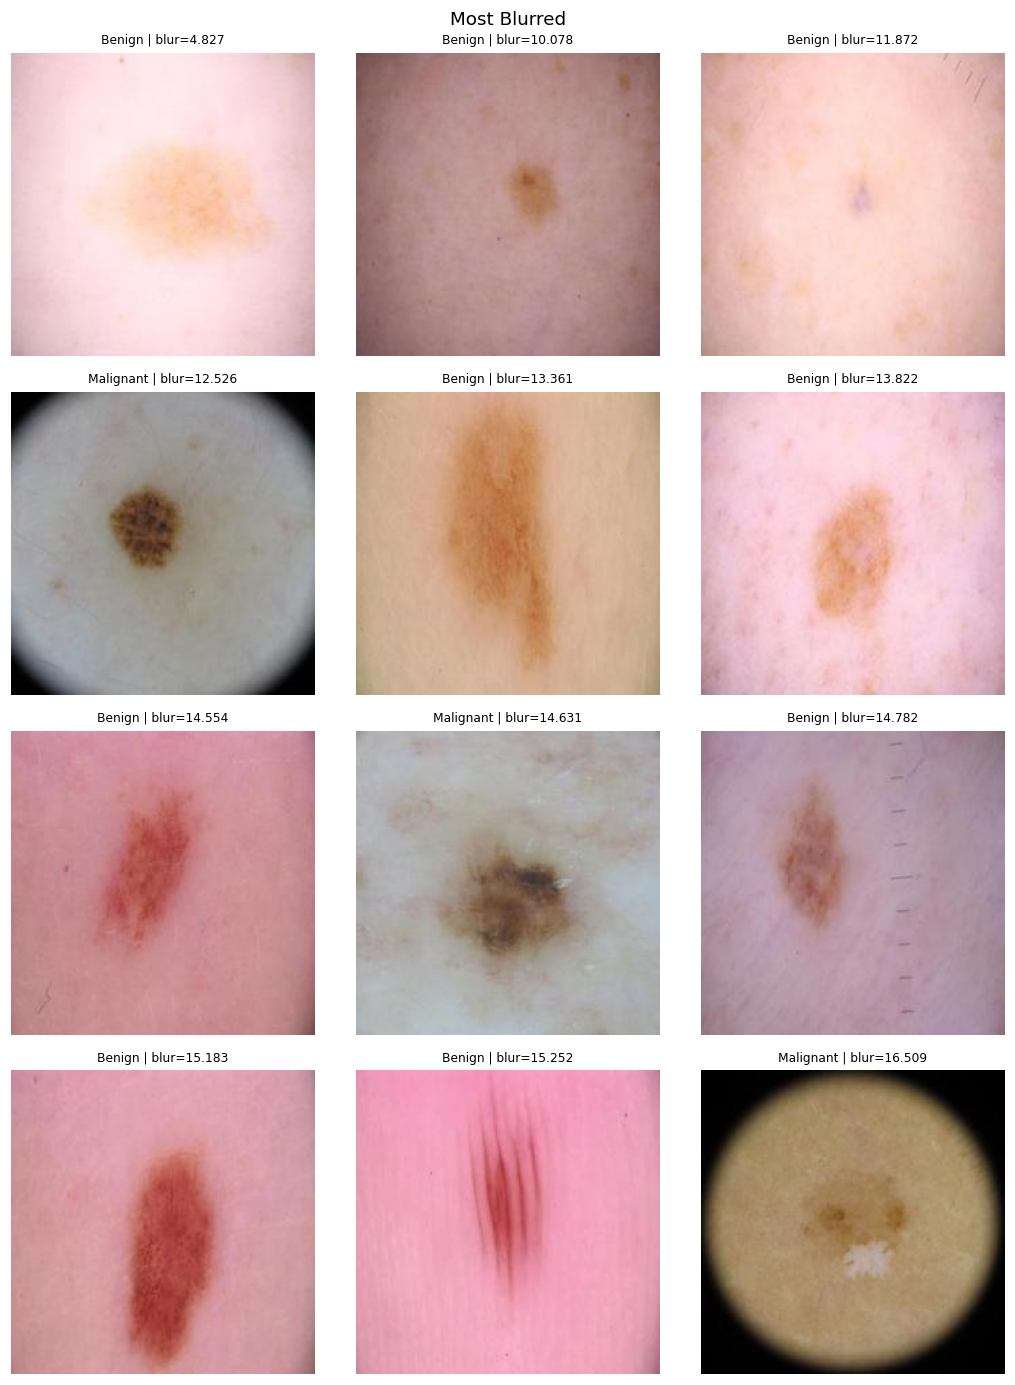

In [39]:
# Most blurred, low blur score
show_panel(top_k(sample_train, "blur", k=12, largest=False), "blur", "Most Blurred")

Las imágenes con `blur < 15` presentan **baja nitidez y contraste**, pero siguen siendo interpretables. La mayoría pertenecen a la clase *Benign*, aunque también aparecen algunos casos *Malignant*. No se aprecia un patrón sistemático: el desenfoque parece **relacionado con la calidad de captura**, no con la etiqueta.

* Los valores bajos de blur confirman un pequeño grupo con **enfoque débil o iluminación plana**, pero el rango global (p50 = 54.5, p95 ≈ 1 489) indica que **la mayoría del dataset es nítido y usable**.
* No se justifica eliminar imágenes: la ligera variabilidad en enfoque **contribuye a la robustez del modelo**.

> **Mantener todas las imágenes.** No aplicar filtrado por nitidez; el desenfoque leve aporta **diversidad óptica controlada**.

**<u>Síntesis general del panel de *outliers*</u>**

| Factor                       |                Nivel de presencia               | Impacto potencial                           | Acción recomendada                 |
| :--------------------------- | :---------------------------------------------: | :------------------------------------------ | :--------------------------------- |
| **Viñeteado (Dark Borders)** | Bajo en promedio, pero severo en un subconjunto | Puede correlacionar con clase (*Malignant*) | Activar `Vignette Mask` opcional   |
| **Pelo (hair proxy)**        |  Moderado–alto, con falsos positivos puntuales  | Reduce legibilidad y textura                | Activar `Hair Removal` por defecto |
| **Blur (enfoque)**           |                 Leve, no sesgado                | Poca afectación                             | Mantener tal cual                  |

El dataset muestra una **calidad visual globalmente buena**, pero con **dos artefactos específicos (viñeteado y pelo)** que conviene tratar antes del entrenamiento para evitar **correlaciones espurias**. El **pipeline de preprocesado** deberá incluir:

* `hair_removal = True` (por defecto, en todos los perfiles).
* `vignette_mask = True` (selectivo: aplicado solo a imágenes afectadas o de forma ligera global).
* **Sin filtrado por blur.**

## **Informe JSON para MLOps ligero**

Esta celda **serializa las métricas clave del EDA** en un archivo **JSON**. El informe incluye **conteos por clase**, **ratio de desbalance**, **estadísticos geométricos** (área y **aspect ratio**), indicadores de **viñeteado** (*dark-border ratio*), **pelo** (*hair proxy*), **nitidez** (**blur** por varianza del Laplaciano), y **estadísticos de color por clase** (**R, G, B, H, S**). El objetivo es generar un **artefacto auditable** y **consumible por código**, que capture exactamente **qué datos y valores** sustentan las decisiones posteriores.

Este informe permite **automatizar decisiones de preprocesado y perfiles de color** en los siguientes notebooks: activar o no **`Vignette Mask`**, aplicar **`Hair Removal`**, y elegir entre **`RGB + H`** o **`RGB + S`** (además del **`RGB Baseline`**). Al centralizar estas señales en un único fichero, se refuerza la **trazabilidad entre fases**, se facilita la **reproducibilidad** de experimentos y se evita la dependencia de inspecciones manuales dispersas.

In [40]:
report = {
    "counts": {
        "train": train_df["label"].value_counts().to_dict(),
        "test":  test_df["label"].value_counts().to_dict()
    },
    "imbalance_ratio": {
        "train": float((train_df["label"].value_counts().max() / train_df["label"].value_counts().min()) if train_df["label"].nunique()>1 else 1.0),
        "test":  float((test_df["label"].value_counts().max()  / test_df["label"].value_counts().min())  if test_df["label"].nunique()>1 else 1.0)
    },
    "aspect_ratio": {
        "train_p01_p99": np.percentile(train_df["width"]/train_df["height"], [1,99]).round(3).tolist(),
        "test_p01_p99":  np.percentile(test_df["width"]/test_df["height"],  [1,99]).round(3).tolist()
    },
    "duplicates": {
        "train_exact": int(train_df['hash'].duplicated(keep=False).sum()),
        "test_exact":  int(test_df['hash'].duplicated(keep=False).sum()),
    },
    "dark_border": {
        "sample_mean": float(np.mean(sample_train["dark_ratio"])),
        "p75": float(sample_train["dark_ratio"].quantile(0.75)),
        "p90": float(sample_train["dark_ratio"].quantile(0.90))
    },
    "hair_proxy": {
        "median": float(np.nanmedian(sample_train["hair_proxy"])),
        "p90": float(np.nanpercentile(sample_train["hair_proxy"].dropna(), 90)) if sample_train["hair_proxy"].notna().any() else None
    },
    "blur": {
        "p5_p50_p95": np.nanpercentile(sample_train["blur"], [5,50,95]).round(1).tolist() if sample_train["blur"].notna().any() else None
    },
    "color_means_by_label": {k:v for k,v in sample_stats.groupby("label")[["R","G","B","H","S"]].mean().round(3).to_dict().items()}
}

In [41]:
with open(RESULTS_ROOT / "eda_report.json", "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

print("[OK] EDA report saved: ", RESULTS_ROOT / "eda_report.json")

[OK] EDA report saved:  results\eda_report.json
